In [1]:
# basics
from datetime import datetime
import time
import os 
import random
# import gresearch_crypto

# plotting
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
# correlation heatmap
from bokeh.io import output_notebook, show
from bokeh.models import (
    BasicTicker,
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    PrintfTickFormatter,
)
from bokeh.plotting import figure
from bokeh.transform import transform

# ml shit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
# stat shit
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
# models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor


data_root = "../data/"
SEED = 2021
REMOVE_LB_TEST_OVERLAPPING_DATA = True

In [2]:
#basic functions

#this one is prob redundant
to_datetime = lambda timestamp: datetime.strftime(datetime.fromtimestamp(timestamp),"%Y-%m-%d")

get_month_timestamp = lambda timestamp: to_datetime(timestamp).month

get_month = lambda datetime: datetime.month

get_month_day = lambda datetime: datetime.strftime("%m-%d")

############# Two new features from the competition tutorial
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def roll(array, shift):
    # this supposebly improves the performance of np.roll
    if not (isinstance(array, np.ndarray)):
        array = np.asarray(array)
    idx = shift%len(array)
    return np.concatenate([array[-idx:], array[:-idx]])


############# from lightGBT tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

############# realized here needs to use some data for calculation of initial values
def realized(close, N=240):
    rt = list(np.log(C_t / C_t_1) for C_t, C_t_1 in zip(close[1:], close[:-1]))
    rt_mean = sum(rt) / len(rt)
    return np.sqrt(sum((r_i - rt_mean) ** 2 for r_i in rt) * N / (len(rt) - 1))

########## function for calling all feature creating functions
def get_features(df, Lag=True):
    df_feat = df[["Count", "Open","High", "Low", "Close", "Volume","VWAP", "Target"]].copy()
    
    df_feat["Upper_shadow"] = upper_shadow(df_feat)
    df_feat["Lower_shadow"] = lower_shadow(df_feat)

    df_feat["Volume"] = log_return(df_feat["Volume"]) # maybe Volume is fine just like that(?)
    df_feat["Count"] = log_return(df_feat["Count"])
    df_feat["VWAP"] = log_return(df_feat["VWAP"])
    df_feat = df_feat[1:] # compensate
    if Lag:
        for lag in range(1, 6):
            roll_feature = "VWAP"
            df_feat["rolled_"+roll_feature+f"_{lag}"] = \
                roll(df_feat[roll_feature].values, lag)
    
    ########### for now, simple dropna()     ########### 
    ########### later we can use reindexing  ########### 
    df_feat.dropna(inplace=True)
    # df_feat = df_feat.reindex(range(btc.index[0],btc.index[-1]+60, 60), method="pad")

    return df_feat


def Xy_model_asset(train, asset_id, Lag=True):
    df = train[train["Asset_ID"]==asset_id]

    # todo : try different features here 
    #        also, scale the features
    df_proc = get_features(df, Lag)

    df_proc["y"] = df["Target"]
    # 念の為
    df_proc.dropna(how="any", inplace=True)
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]

    # todo : try different models here
    # model = LGBMRegressor()
    # model.fit(X, y)
    return X, y#, model


def scorer(model, X, y):
    # not sure how this line works, just trying
    y_pred = model.predict([X])[0]
    score = np.corrcoef(y_pred, y)
    return score

my_scorer = make_scorer(scorer)

In [3]:
df = pd.read_csv(data_root+"train.csv")
assets = pd.read_csv(data_root+"asset_details.csv")
df_grouped = df.groupby("Asset_ID")

In [4]:
btc = df_grouped.get_group(1)
eth = df_grouped.get_group(6)

btc.set_index("timestamp", inplace=True)
btc = btc.drop(columns=["Target", "Asset_ID"])
btc = btc.add_suffix("_btc")
eth.set_index("timestamp", inplace=True)
eth = eth.drop(columns=["Target", "Asset_ID"])
eth = eth.add_suffix("_eth")

btc_eth = pd.concat([btc, eth], axis=1)

btc_eth.fillna(method="ffill", inplace=True)

btc_eth

,Count_btc,Open_btc,High_btc,Low_btc,Close_btc,Volume_btc,VWAP_btc,Count_eth,Open_eth,High_eth,Low_eth,Close_eth,Volume_eth,VWAP_eth
timestamp,,,,,,,,,,,,,,
1514764860,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,173.0,738.302500,746.00,732.51,738.507500,335.987856,738.839291
1514764920,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,192.0,738.507500,745.14,732.49,738.260000,232.793141,738.268967
1514764980,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,120.0,738.332500,745.12,730.00,737.502500,174.138031,737.994457
1514765040,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,156.0,737.222500,744.69,728.93,737.102500,165.383926,737.303631
1514765100,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,118.0,736.530000,743.80,727.11,735.705000,193.078039,736.163026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632182160,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,2162.0,2973.728686,2976.10,2962.09,2964.711429,751.256906,2968.339295
1632182220,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,1976.0,2965.461446,2967.95,2958.05,2960.845714,729.113672,2963.499199
1632182280,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,2262.0,2960.321429,2962.60,2954.14,2957.398571,807.935362,2958.464868


In [5]:
df_features = btc_eth.copy()
suffixes = ["_btc", "_eth"]

for suffix in suffixes:
    df_features["logprice"+suffix] = np.log(df_features["Close"+suffix]) 
    df_features["Volatility"+suffix] = np.log(df_features["High"+suffix])\
        - np.log(df_features["Close"+suffix])
    df_features = df_features.drop(columns=["Close"+suffix, "High"+suffix,\
         "Low"+suffix, "Open"+suffix, "VWAP"+suffix])

def get_time_fractions(date):

    def s(date):# returns seconds since epoch
        return time.mktime(date.timetuple())

    year = date.year
    month = date.month
    day = date.day
    dayofweek = date.dayofweek

    start_of_day = datetime(year = year, month = month, day = day, hour = 0, minute = 0, second = 0)
    day_sec = 60*60*24

    frac_day = (s(date) - s(start_of_day))/day_sec # how much time has passed during that day

    frac_week  = (dayofweek + frac_day) / 7 # how much time has passed during the week

    start_of_month = datetime(year=year, month=month, day=1)
    start_of_next_month = datetime(year=year, month=month+1, day=1) if month < 12 \
        else datetime(year=year+1, month=1, day=1)
    # here we use datetime function because we don't know how many days this next month is 
    frac_month = (s(date) - s(start_of_month)) / (s(start_of_next_month) - s(start_of_month))

    start_of_year = datetime(year=year, month=1, day=1)
    start_of_next_year = datetime(year=year+1, month=1, day=1)

    frac_year = (s(date) - s(start_of_year)) / (s(start_of_next_year) - s(start_of_year))

    return frac_day, frac_week, frac_month, frac_year

datetimes = pd.Series(df_features.index).astype("datetime64[s]")

df_features["frac_day"], df_features["frac_week"], df_features['frac_of_month'], \
    df_features['frac_of_year'] = zip(*datetimes.map(get_time_fractions))

df_features

,Count_btc,Volume_btc,Count_eth,Volume_eth,logprice_btc,Volatility_btc,logprice_eth,Volatility_eth,frac_day,frac_week,frac_of_month,frac_of_year
timestamp,,,,,,,,,,,,
1514764860,229.0,31.550062,173.0,335.987856,9.536053,0.011745,6.604631,0.010094,0.000694,0.000099,0.000022,0.000002
1514764920,235.0,31.046432,192.0,232.793141,9.534458,0.016083,6.604296,0.009276,0.001389,0.000198,0.000045,0.000004
1514764980,528.0,55.061820,120.0,174.138031,9.532519,0.014322,6.603269,0.010276,0.002083,0.000298,0.000067,0.000006
1514765040,435.0,38.780529,156.0,165.383926,9.530105,0.016636,6.602727,0.010241,0.002778,0.000397,0.000090,0.000008
1514765100,742.0,108.501637,118.0,193.078039,9.526968,0.016690,6.600829,0.010943,0.003472,0.000496,0.000112,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...
1632182160,1940.0,56.850913,2162.0,751.256906,10.666604,0.002394,7.994535,0.003834,0.997222,0.142460,0.666574,0.720540
1632182220,2026.0,80.993326,1976.0,729.113672,10.665694,0.001678,7.993230,0.002397,0.997917,0.142560,0.666597,0.720542
1632182280,1986.0,65.677734,2262.0,807.935362,10.664924,0.001411,7.992065,0.001757,0.998611,0.142659,0.666620,0.720544


In [6]:
# calculate 2-asset targets(not 14 asset target)

df_logprices = df_features[["logprice_btc", "logprice_eth"]]

# 𝑅𝑎(𝑡)=𝑙𝑜𝑔(𝑃𝑎(𝑡+16) / 𝑃𝑎(𝑡+1))=𝑙𝑜𝑔(𝑃𝑎(𝑡+16)−𝑙𝑜𝑔(𝑃𝑎(𝑡+1)
df_returns = df_logprices.shift(-16) - df_logprices.shift(-1)

for suffix in suffixes:
    df_returns.rename(columns={"logprice"+suffix : "R"+suffix}, inplace=True)


In [7]:
assets =  assets[(assets["Asset_ID"] == 1) | (assets["Asset_ID"] == 6)]

assets = assets.sort_values(by=["Asset_ID"])

weights = assets["Weight"].to_numpy()
weights = weights.reshape(len(weights), 1)



(2, 1)

In [8]:
R = df_returns.to_numpy()# to array
weights_sum = np.sum(weights)
M = np.dot(R, weights) / weights_sum # weighted average => log_btc*w_btc + log_eth*w_eth
df_M = pd.DataFrame(data=M, index=df_returns.index, columns=["M"])
R.shape,weights.shape, M.shape

((1956405, 2), (2, 1), (1956405, 1))

In [9]:
df_R_M = df_returns.copy()

for col in df_R_M.columns:
    df_R_M[col] = df_R_M[col] * df_M["M"] # calculated R・M here
for suffix in suffixes:
    df_R_M.rename(columns={"R"+suffix:"R_M"+suffix}, inplace=True)
df_R_M_rolling = df_R_M.rolling(window=3750).mean()
df_R_M_rolling

,R_M_btc,R_M_eth
timestamp,,
1514764860,NaN,NaN
1514764920,NaN,NaN
1514764980,NaN,NaN
1514765040,NaN,NaN
1514765100,NaN,NaN
...,...,...
1632182160,NaN,NaN
1632182220,NaN,NaN
1632182280,NaN,NaN


In [10]:

# creating M^2 
df_M2 = df_M ** 2
df_M2.rename(columns={"M" : "M2"}, inplace = True)
df_M2_rolling = df_M2.rolling(window=3750).mean()


df_betas = df_R_M_rolling.copy()    
for col in df_betas.columns: # columns = [R_M_btc	R_M_eth]   
    df_betas[col] = df_betas[col] / df_M2_rolling["M2"] # caculating <R・M>/<M^2> here
for suffix in suffixes: # beta = <R・M>/<M^2> 
    df_betas.rename(columns={"R_M"+suffix : "beta"+suffix}, inplace = True)

df_targets = df_returns.copy()
for suffix in suffixes:
    df_targets["R"+suffix] -= df_betas["beta"+suffix] * df_M["M"] # R^a - β^a
    df_targets.rename(columns={"R"+suffix: "Target"+suffix}, inplace=True)

df_features_targets = pd.concat([df_features, df_betas, df_targets], axis=1)

df_features_targets = df_features_targets.iloc[3750:-16] # drop nan rows

df_features_targets

,Count_btc,Volume_btc,Count_eth,Volume_eth,logprice_btc,Volatility_btc,logprice_eth,Volatility_eth,frac_day,frac_week,frac_of_month,frac_of_year,beta_btc,beta_eth,Target_btc,Target_eth
timestamp,,,,,,,,,,,,,,,,
1514989860,580.0,109.791491,223.0,329.901996,9.617336,0.010023,6.772239,0.007694,0.604861,0.372123,0.084028,0.007137,0.982478,1.020155,-0.001043,0.001199
1514989920,248.0,24.724641,218.0,170.856047,9.616709,0.013669,6.773209,0.005485,0.605556,0.372222,0.084050,0.007139,0.982038,1.020660,-0.001571,0.001807
1514989980,225.0,50.562247,134.0,161.003980,9.617417,0.009942,6.773223,0.005095,0.606250,0.372321,0.084073,0.007140,0.981861,1.020864,-0.001181,0.001358
1514990040,223.0,35.199453,275.0,225.537830,9.617911,0.010482,6.773655,0.006267,0.606944,0.372421,0.084095,0.007142,0.981713,1.021034,-0.001245,0.001432
1514990100,386.0,67.987783,189.0,302.293089,9.617057,0.011335,6.773647,0.006309,0.607639,0.372520,0.084117,0.007144,0.981607,1.021156,-0.001071,0.001232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,2643.0,100.797218,2291.0,717.616863,10.662039,0.000779,7.992852,0.000899,0.986111,0.140873,0.666204,0.720510,0.856287,1.165303,0.001644,-0.001891
1632181260,2281.0,76.339988,2534.0,776.638911,10.663872,0.000874,7.994945,0.000934,0.986806,0.140972,0.666227,0.720512,0.856290,1.165300,0.002057,-0.002366
1632181320,2642.0,117.429123,2321.0,976.724995,10.663255,0.001671,7.995076,0.001002,0.987500,0.141071,0.666250,0.720514,0.856298,1.165291,0.001882,-0.002165


In [11]:
def plot_heatmap(absolute = True):

    output_notebook()

    df_to_viz = df_features_targets
    if absolute:
        xcorr = abs(df_to_viz.corr())
    else:
        xcorr = df_to_viz.corr()
    xcorr.index.name = "Feature1"
    xcorr.columns.name = "Feature2"

    df = pd.DataFrame(xcorr.stack(), columns=["Corr"]).reset_index()

    source = ColumnDataSource(df)

    colors = [
        "#75968f",
        "#a5bab7",
        "#c9d9d3",
        "#e2e2e2",
        "#dfccce",
        "#ddb7b1",
        "#cc7878",
        "#933b41",
        "#550b1d",
    ]

    mapper = LinearColorMapper(palette=colors, low=df.Corr.min(), high=df.Corr.max())

    f1 = figure(
        plot_width=800,
        plot_height=800,
        title="Correlation Heat Map",
        x_range=list(sorted(xcorr.index)),
        y_range=list(reversed(sorted(xcorr.columns))),
        toolbar_location=None,
        tools="hover",
        x_axis_location="above",
    )

    f1.rect(
        x="Feature2",
        y="Feature1",
        width=1,
        height=1,
        source=source,
        line_color=None,
        fill_color=transform("Corr", mapper),
    )

    color_bar = ColorBar(
        color_mapper=mapper,
        location=(0, 0),
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
    )
    f1.add_layout(color_bar, "right")

    f1.hover.tooltips = [
        ("Feature1", "@{Feature1}"),
        ("Feature2", "@{Feature2}"),
        ("Corr", "@{Corr}{1.1111}"),
    ]

    f1.axis.axis_line_color = None
    f1.axis.major_tick_line_color = None
    f1.axis.major_label_text_font_size = "12px"
    f1.axis.major_label_standoff = 2
    f1.xaxis.major_label_orientation = 1.0

    show(f1)

plot_heatmap()

Loading BokehJS ...

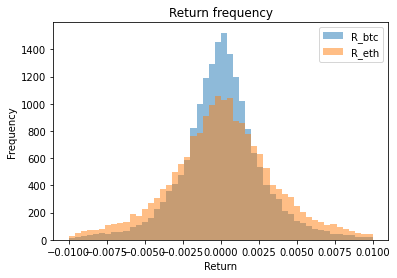

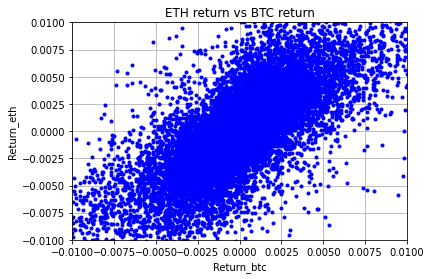

In [12]:
df_to_plot = df_returns.iloc[::100]
df_to_plot[(np.abs(df_to_plot["R_btc"]) < 0.01) & (np.abs(df_to_plot["R_eth"]) < 0.01)].plot.hist(bins=50, alpha=0.5)
plt.xlabel("Return")
plt.title("Return frequency")
plt.show()

plt.plot(df_to_plot["R_btc"], df_to_plot["R_eth"], '.b')
plt.xlim([-0.01, 0.01])
plt.ylim([-0.01, 0.01])
plt.xlabel("Return_btc")
plt.ylabel("Return_eth")
plt.grid()
plt.title("ETH return vs BTC return")
plt.show()

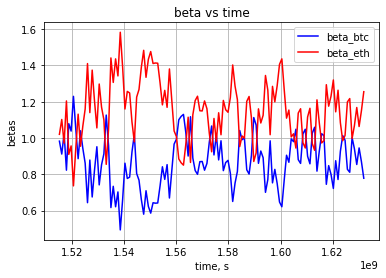

In [13]:
y1 = df_features_targets["beta_btc"].iloc[::15000]
y2 = df_features_targets["beta_eth"].iloc[::15000]
plt.plot(y1, '-b', label="beta_btc")
plt.plot(y2, '-r', label="beta_eth")
plt.xlabel("time, s")
plt.ylabel("betas")
plt.legend()
plt.grid()
plt.title("beta vs time")
plt.show()

<AxesSubplot:ylabel='Frequency'>

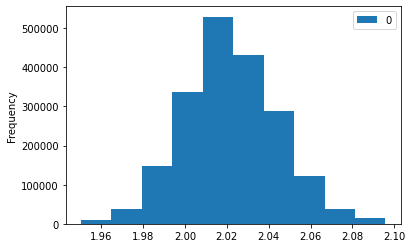

In [14]:
pd.DataFrame(df_features_targets["beta_btc"] + df_features_targets["beta_eth"]).plot.hist()

In [ ]:
df_features_targets